# Potential plots etc, for irene monitor

In [1]:
import os
import sys
import tables as tb
import numpy  as np
from matplotlib import pyplot as plt
from glob import glob

from invisible_cities.cities.irene      import Irene
from invisible_cities.cities.irene_test import unpack_s12params, s12params
from invisible_cities.types.ic_types_c import minmax
from invisible_cities.core.system_of_units_c import units
from invisible_cities.core.configure         import configure
from invisible_cities.reco import peak_functions_c as cpf
from invisible_cities.reco import peak_functions   as  pf
from invisible_cities.io   import pmap_io          as pio
from invisible_cities.evm .pmaps import S1, S2, S2Si, Peak
sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')
import icaro.marco_polo.monitor_functions as mf
montecarlo = False

In [6]:
ic_data = os.path.join(os.environ['IC_DATA'])
# MONTECARLO
if montecarlo:
    run = 0
    conf_path = '/Users/alej/Desktop/Valencia/nextic/IC-1/invisible_cities/config/irene.conf'
    PATH_IN  = ic_data + 'Montecarlo/Kr/new_mc/dst_NEXT_v1_00_05_Kr_ACTIVE_0_0_7bar_RWF_1000.root.h5'
    PATH_OUT  = ic_data + 'Montecarlo/Kr/new_mc/dst_NEXT_v1_00_05_Kr_ACTIVE_0_0_7bar_pmaps_1000.root.h5'
    pmap_path = PATH_OUT
    rwf_path = PATH_IN
# Kr
else:
    run = 4446
    PATH_IN  = ic_data + 'LSC/wvfms/4446/dst_waves.gdcsnext.*.root.h5'
    conf_path = '/Users/alej/Desktop/irene/irene.conf'
    PATH_OUT  = '/Users/alej/Desktop/irene/full_chain/Kr_4446_full_chain.h5'
    pmap_path = PATH_OUT
    rwf_path = ic_data + '/LSC/wvfms/4446/dst_waves.gdcsnext.1840_4446.root.h5'

In [68]:
# initialize irene
#PATH_IN  = os.path.join(rwf_path)
PATH_OUT = os.path.join(PATH_OUT)
conf     = configure(('dummy ' + conf_path).split()).as_dict
if montecarlo:
    conf.update(dict(run_number = run,
                 files_in   = PATH_IN,
                 file_out   = PATH_OUT,
                 nmax       = 1000,
                 **unpack_s12params(s12params())))
else:
    conf.update(dict(run_number = run,
                 files_in   = PATH_IN,
                 file_out   = PATH_OUT,
                 nmax       = 1000))

irene = Irene(**conf)
irene.thr_sipm    =  2*units.pes
irene.thr_sipm_s2 = 15*units.pes
#irene.run() # Turn on to generate new pmap_path

## First, check that we have pmaps

In [90]:
with tb.open_file(rwf_path, 'r+') as f_rwfs:
    events = [f_rwfs.root.Run.events[i][0] for i in range(len(f_rwfs.root.Run.events[:]))]
#nevts = irene.cnt.cd['n_events_tot']
nevts = 1002
s1_dict, s2_dict, s2si_dict = pio.load_pmaps(pmap_path)

#### Ensure there are no empty s1d, s2d, s2sid

In [91]:
# Check to make sure no empty dictionaries (not sure if empty Si is allowed..)
for si_dict in [s1_dict, s2_dict, s2si_dict]:
    for si in si_dict.values():
        try: 
            for peak in si.s1d.values():
                assert len(peak) > 0
        except AttributeError:
            try:
                for peak in si.s2sid.values():
                    assert len(peak) > 0
            except AttributeError: 
                for peak in si.s2d.values():
                    assert len(peak) > 0           

#### Look at the numbers of s1, s2, s2si

Number of events                               : 1002
Fract. of events with at least one s1, s2, s2si: 0.9121756487025948 1.001996007984032 0.9970059880239521
Total S1, S2, s2si                             : 8224  1118  1071


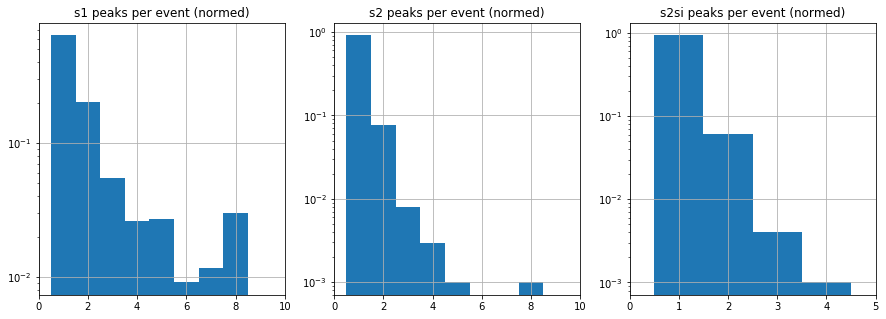

In [92]:
ns1 = 0; ns2 = 0; ns2si = 0
nbins = 10
s1_peaks   = []
s2_peaks   = []
s2si_peaks = []
for s1   in s1_dict  .values(): ns1   += len(s1.s1d)    ; s1_peaks  .append(len(s1  .s1d))
for s2   in s2_dict  .values(): ns2   += len(s2.s2d)    ; s2_peaks  .append(len(s2  .s2d))
for s2si in s2si_dict.values(): ns2si += len(s2si.s2sid); s2si_peaks.append(len(s2si.s2sid))
print('Number of events                               :', nevts)
print('Fract. of events with at least one s1, s2, s2si:', len(s1_dict  )/nevts, 
                                                          len(s2_dict  )/nevts, 
                                                          len(s2si_dict)/nevts)
print('Total S1, S2, s2si                             :', ns1,'',ns2,'',ns2si)

subplot=131
plt.figure(figsize=(15,5))
for si_peaks, title in zip([s1_peaks, s2_peaks, s2si_peaks], ['s1', 's2', 's2si']):
    si_peaks=np.array(si_peaks)
    plt.subplot(subplot)
    plt.hist(si_peaks, bins=range(nbins), align='left', normed=True)
    if si_peaks.max() > 1: plt.yscale('log')
    plt.xlim(0, si_peaks.max() + 1)
    if title == 's1': plt.xlim(0,10)
    plt.title(title + ' peaks per event (normed)')
    plt.grid(True)
    subplot+=1
plt.show()

#### Housekeeping

In [47]:
# Get some csums
def calibrated_waveforms(events, irene, rwf_path, pmts=True, sipms=True):
    with tb.open_file(rwf_path ,'r') as f:
        CSUMs  = {}
        csipm  = {}
        for ev in events:
            if pmts : 
                CSUMs[ev] = irene.calibrated_pmt_sum(irene.deconv_pmt(f.root.RD.pmtrwf[ev]))[0]
                
                
            if sipms: csipm[ev] = irene.calibrated_signal_sipm(f.root.RD.sipmrwf[ev]).sum(axis=0)
    return CSUMs, csipm

# Plot some histograms for comparing positive and negative sections of wf
def compare_pos_neg_hist(arrs, titles, log=False, normed=False):
    plt.figure(figsize=(15,4))
    subplot=121
    for h, title in zip(arrs, titles):
        plt.subplot(subplot)
        plt.hist(h, normed=normed, bins=20)
        plt.grid(True)
        plt.title(title)
        if log: plt.yscale('log')
        plt.xlabel('pes')
        subplot+=1
    plt.show()

## Study of csum waveforms

In [48]:
events   = mf.sample_events(-1, rwf_path, all_events=True)
i_events = events - events[0]
if montecarlo:
    events = list(range(100))
    i_events = events
CSUMs, _ = calibrated_waveforms(i_events, irene, rwf_path, sipms=False)

In [49]:
def compare_pos_neg_hist(arrs, titles, log=False, normed=False, xlabel='pes'):
    plt.figure(figsize=(15,4))
    subplot=121
    for h, title in zip(arrs, titles):
        plt.subplot(subplot)
        plt.hist(h, normed=normed, bins=20)
        plt.grid(True)
        plt.title(title)
        if log: plt.yscale('log')
        plt.xlabel(xlabel)
        subplot+=1
    plt.show()

#### Min and max values in csum

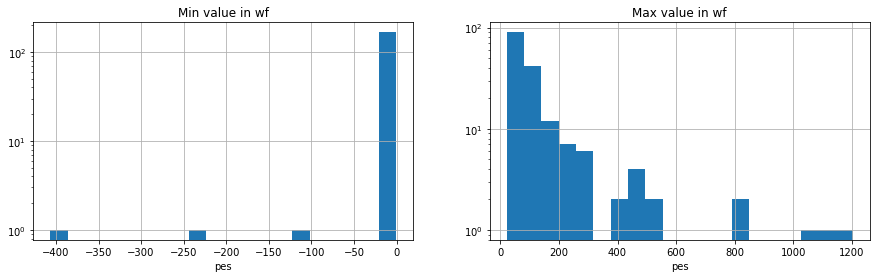

In [50]:
MIN = []
MAX = []
for fpmt in CSUMs.values():
    MIN.append(fpmt.min())
    MAX.append(fpmt.max())
compare_pos_neg_hist([MIN,MAX], ['Min value in wf', 'Max value in wf'], log=True)

#### Number of positive and negative entries in csum

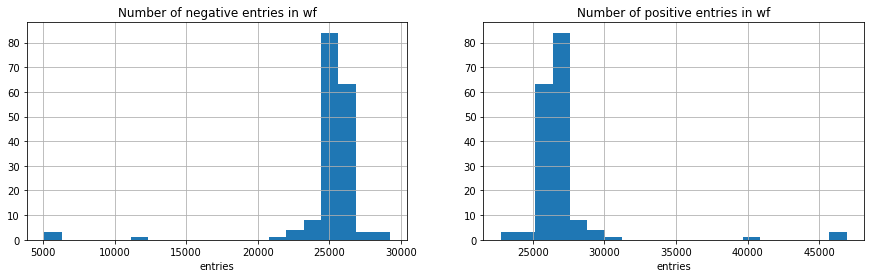

In [51]:
POSen = []
NEGen = []
for fpmt in CSUMs.values():
    POSen.append(len(np.where(fpmt > 0)[0])) # n pos bins
    NEGen.append(len(np.where(fpmt < 0)[0])) # n neg bins
compare_pos_neg_hist([NEGen,POSen], 
                     ['Number of negative entries in wf', 
                      'Number of positive entries in wf'], 
                     log=False, xlabel='entries')

#### Sum of csum above and below 0

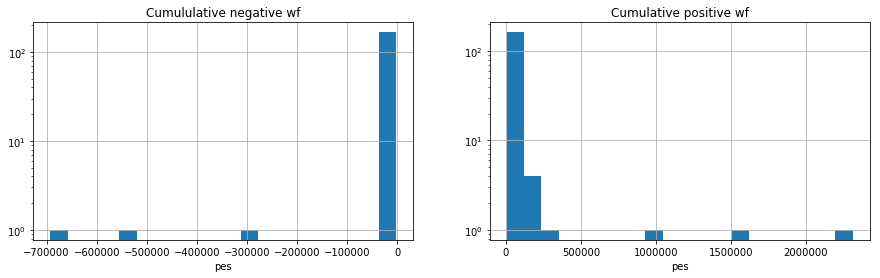

In [52]:
POS = []
NEG = []
for fpmt in CSUMs.values():
    POS.append(fpmt[np.where(fpmt > 0)[0]].sum()) # sum of all pos bins
    NEG.append(fpmt[np.where(fpmt < 0)[0]].sum()) # sum of all neg bins
compare_pos_neg_hist([NEG,POS], ['Cumululative negative wf', 'Cumulative positive wf'], log=True)

#### Mean positive and negative csum

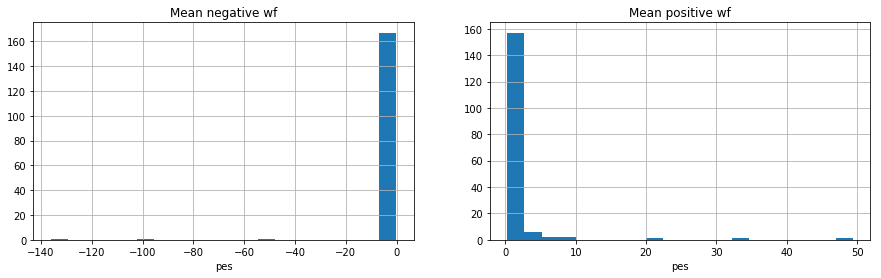

In [53]:
POSn = []
NEGn = []
for fpmt in CSUMs.values():
    POSn.append(fpmt[np.where(fpmt > 0)[0]].sum() / len(np.where(fpmt > 0)[0])) # div by n pos bins
    NEGn.append(fpmt[np.where(fpmt < 0)[0]].sum() / len(np.where(fpmt < 0)[0])) #     by n neg bins
compare_pos_neg_hist([NEGn,POSn], ['Mean negative wf', 'Mean positive wf'], log=False)

Once we start saving the individual pmt S2s, we can make similar plots with those. 

## Check that the peaks of a random sample of individual events make sense

In [54]:
# Plot Peak and WF on top of each other
def plot_wf_vs_s12_peak(csum, peak,
                        subplot = -1, 
                        wfbs    = 25*units.ns,
                        pkbs    = 25*units.ns,
                        S12     = 'S1', 
                        plotwf  = plt.scatter, 
                        plotp   = plt.scatter,
                        pc      = 'r'):
    
    if subplot != -1: plt.subplot(subplot)
        
    # helpful since rebinning algorithm record average time 
    t = np.copy(peak.t)
    if S12=='S2Si': t-= 500  *units.ns # typically  1mus time bins 
        
    plotwf(np.arange(len(csum))*wfbs/units.mus, csum, label='wf', s=300, alpha=.3) # Plot wf
    plotp(t/units.mus, peak.E *wfbs/pkbs, label=S12, alpha=.5, c=pc)              # Plot peak
    plt.xlim((peak.t[0] - 2*pkbs) / units.mus, (t[-1] + 2*pkbs)/units.mus) # Set xlim around peak
    plt.ylim(0, peak.E.max()*wfbs/pkbs + .25*peak.E.max()*wfbs/pkbs)      # Set ylim around peak
    plt.legend()
    plt.grid(True)
    plt.ylabel('pes')
    plt.xlabel('time (microseconds)')

#### Get a small random sample of events
Need calibrated sums of pmts and sipms

In [55]:
ev_sample = mf.sample_events(9, rwf_path)
i_ev = ev_sample - events[0]
CSUMs, csipm = calibrated_waveforms(i_ev, irene, rwf_path, sipms=True)

#### Some S1s
These should be exact copies of the waveform since there is no rebinning

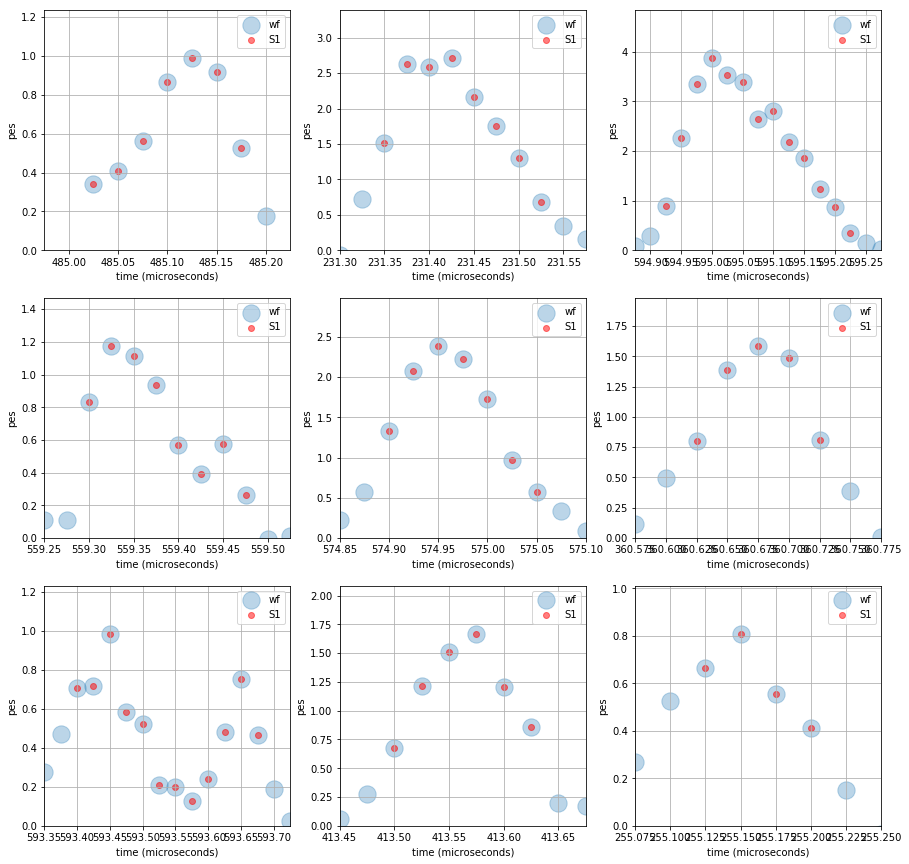

In [56]:
plt.figure(figsize=(15,15))
subplot=331
for i, ev in zip(i_ev, ev_sample):
    if ev in s1_dict:
        pn = np.array(list(s1_dict[ev].peaks.keys())).max() # choose 1 peak_no (here max)
        plot_wf_vs_s12_peak(CSUMs[i], s1_dict[ev].peaks[pn], subplot=subplot)
        subplot+=1
plt.show()

#### Some S2s 
There has been rebinning, so S2 should look like a best fit line to the wf.    
Note: s2 amplitudes have been multipled by (wf time bin size 25ns / s2 time bin size 1000ns) so that amplitudes match    

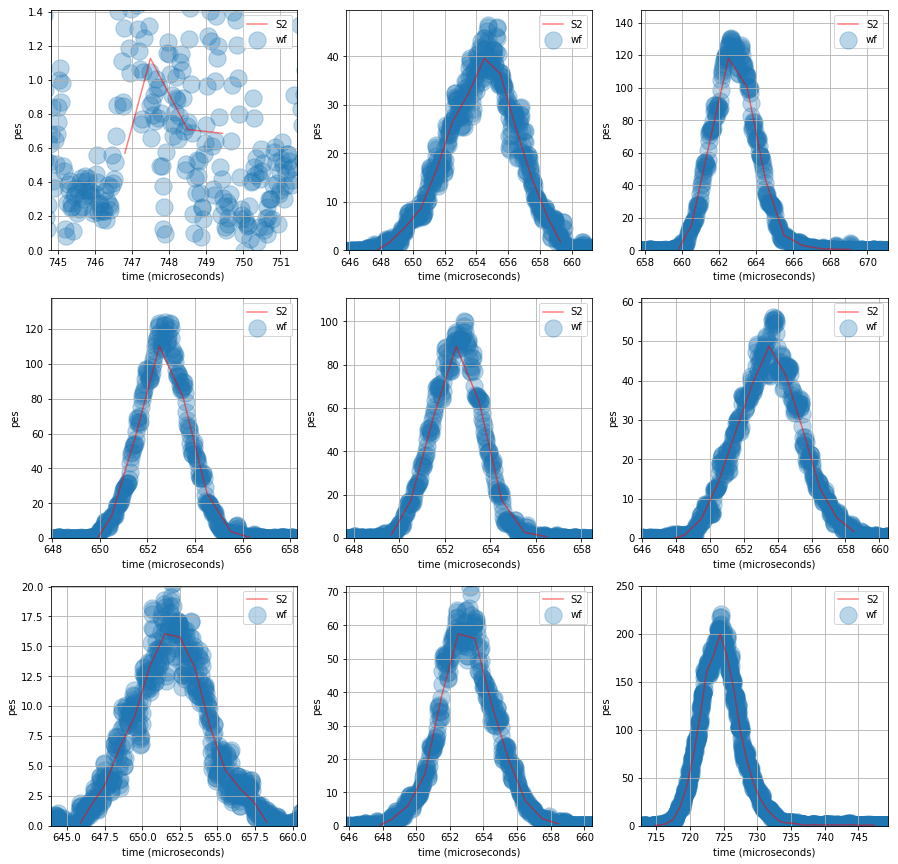

In [57]:
plt.figure(figsize=(15,15))
subplot=331
for i, ev in zip(i_ev, ev_sample):
    if ev in s2_dict:
        pn = np.array(list(s2_dict[ev].peaks.keys())).max()
        plot_wf_vs_s12_peak(CSUMs[i], s2_dict[ev].peaks[pn], 
                            subplot=subplot, 
                            pkbs=units.mus, 
                            plotp=plt.plot,
                            S12='S2',
                            pc='r')    
    subplot+=1
plt.show()

#### Some S2Si
The S2Si should look very similar to the wf. If S2Si threshold is set to zero, data points in the wf and S2Si should match perfectly. Since typically the threshold is quite high ~3.5pes, we cannot expect an exact match between the data points, typically the S2Si peak should be slightly smaller than the peak seen in the wf.   

Note: light arriving to the first SiPM time bin arrives on average at .5mus not at 0mus and `rebin_waveform` takes this into account by construction


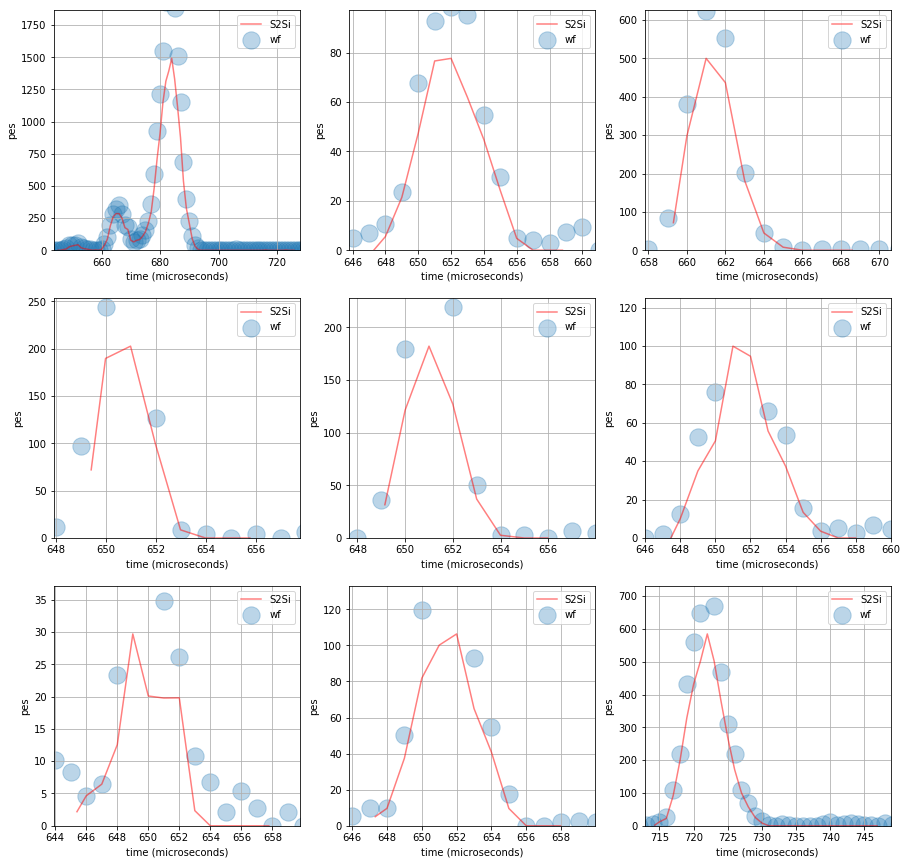

In [58]:
subplot=331
plt.figure(figsize=(15,15))
for i, ev in zip(i_ev, ev_sample):
    if not ev in s2si_dict: continue
    s2si = s2si_dict[ev]
    pn = np.array(list(s2si.peaks.keys())).max()
    t = s2si.s2d[pn][0]
    s2si_sum = np.zeros_like(t)
    for sipm in s2si.s2sid[pn]: 
        s2si_sum += s2si.s2sid[pn][sipm]
    plot_wf_vs_s12_peak(np.array(csipm[i]), Peak(t, s2si_sum),
                        subplot=subplot,
                        wfbs=units.mus,
                        pkbs=units.mus,
                        plotp=plt.plot,
                        S12='S2Si',
                        pc='r')
    subplot+=1
plt.show()

## Future monitor plots etc:

1) Whatever useful information we can get out of acum in sierpe (JJ talked about)    
2) tons of the information contained in the kdst should probably also be used for monitoring; however i assume we want to keep this separate from the irene monitor / avoid writing code multiple times. (heat map, s12 properties, drift time etc)